# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [ ]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
32,C-5320082T,Kia Rio X,economy,petrol,4.36,2013,47354,2020,43.21,electro_bug
959,m-1655829f,VW Tiguan,economy,petrol,6.88,2013,49884,2019,44.13,wheel_shake
1765,X11944438J,Smart Coupe,economy,petrol,4.00,2016,107211,2017,70.15,engine_ignition
1789,J87163790k,Kia Rio X,economy,petrol,4.16,2013,41911,2017,61.86,another_bug
2201,Y-5441952b,Smart Coupe,economy,petrol,5.42,2017,132508,2020,26.44,break_bug


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [ ]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
275003,D54958867b,T-1931494b,t1A,2020-02-14,2.18,43,433,53,67.179627,2,1184.227631,0,16.900941,44.597
155857,V10531886R,L-1950271Y,W1F,2020-03-08,4.93,73,799,54,96.239982,6,3681.838341,0,7.857105,-5.732
74253,s80356437U,F-4198459W,u1d,2020-03-09,0.10,69,822,35,134.000000,0,2215.676889,0,0.519149,19.503
135714,I32804864x,J12910153n,D1k,2020-03-30,4.91,37,513,50,60.255721,0,1721.269820,0,5.690434,5.022
88108,S55861534N,G-6080211i,U1U,2020-02-04,6.95,86,873,36,115.000000,4,1031.973473,0,4.390877,0.723


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [ ]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
11943,37,9.1,863,11.0,T21769368a,0,2019-3-29
9733,26,9.6,1082,17.0,k18573847k,1,2018-11-8
15004,28,8.5,925,7.0,u72820152h,1,2018-12-18
12499,24,9.1,1301,18.0,W17299944T,1,2018-9-11
12507,39,7.7,1234,4.0,A62490665y,0,2021-3-28


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [ ]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
68355,A-3681208u,RX,2019-2-28 22:33,reparking,1.0,22
143265,y22394536i,RW,2019-3-16 19:42,reparking,1.0,23
10387,J-7902945N,AC,2020-2-7 11:40,refuel_check,1.0,30
89281,T-2633971l,JB,2020-7-23 0:31,reparking,1.0,21
22101,T-5659136s,TO,2019-2-6 4:21,repair,5.0,17


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Расчет признаков

In [ ]:
rides_info['ride_date']=pd.to_datetime(rides_info['ride_date'])
rides_agg=rides_info.groupby('car_id', as_index=False).agg(
    # Обязательные
    min_rating = ('rating', 'min'),
    mean_rating = ('rating', 'mean'),
    sum_distance = ('distance', 'sum'),
    max_speed = ('speed_max', 'max'),
    total_rides = ('ride_id', 'count'),
    # Дополнительные
    mean_duration=('ride_duration', 'mean'),  # средняя длительность поездок
    sum_ride_cost=('ride_cost', 'sum'),  # общая сумма оплаты за поездки
    min_ride_date=('ride_date', 'min'),  # дата и время первой поездки
)
rides_agg.head()

,car_id,min_rating,mean_rating,sum_distance,max_speed,total_rides,mean_duration,sum_ride_cost,min_ride_date
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174,1289.034483,2645050,2020-01-01
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174,2148.810345,4699301,2020-01-01
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174,479.017241,800344,2020-01-01
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174,2167.534483,4764037,2020-01-01
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174,1436.614943,2816285,2020-01-01


In [ ]:
# Присоединим к основному датасету
tmp = rides_info.merge(rides_agg, on="car_id", how="left")
tmp = car_train.merge(tmp, on="car_id", how="left")

In [ ]:
tmp.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,user_ride_quality,deviation_normal,min_rating,mean_rating,sum_distance,max_speed,total_rides,mean_duration,sum_ride_cost,min_ride_date
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,0.524750,0.0,0.1,4.737759,1.214131e+07,180.855726,174,1635.770115,3498596,2020-01-01
1,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1.723151,0.0,0.1,4.737759,1.214131e+07,180.855726,174,1635.770115,3498596,2020-01-01
2,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,0.876440,-0.0,0.1,4.737759,1.214131e+07,180.855726,174,1635.770115,3498596,2020-01-01
3,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1.274242,-0.0,0.1,4.737759,1.214131e+07,180.855726,174,1635.770115,3498596,2020-01-01
4,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,0.952363,-0.0,0.1,4.737759,1.214131e+07,180.855726,174,1635.770115,3498596,2020-01-01


In [ ]:
# Соединение таблиц rides_info и driver_info
tmp = tmp.merge(driver_info, on="user_id", how="left")
tmp = tmp.merge(fix_info, on="car_id", how="left")

In [ ]:
tmp.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,user_rating,user_rides,user_time_accident,sex,first_ride_date,worker_id,fix_date,work_type,destroy_degree,work_duration
6255728,z17317811F,Skoda Rapid,economy,petrol,4.02,2015,82696,2018,37.31,break_bug,...,7.8,1003,4.0,0,2021-1-28,GM,2020-9-14 8:37,refuel,1.0,28
6956845,z-2004787O,Smart Coupe,economy,petrol,5.64,2017,114968,2016,32.06,break_bug,...,8.5,693,22.0,0,2019-5-15,EZ,2019-11-3 20:17,repair,6.8,29
10065375,P-4438054o,Smart ForTwo,economy,petrol,4.30,2017,135925,2019,47.10,engine_check,...,8.9,305,NaN,1,2020-5-3,WO,2019-12-26 21:13,reparking,1.0,25
1850046,f11377802P,VW Polo VI,economy,petrol,3.40,2011,1772,2020,70.71,engine_ignition,...,8.2,978,7.0,0,2019-2-29,LK,2019-6-25 21:19,repair,5.0,22
5977569,K-2275807Z,Kia Rio X-line,economy,petrol,4.64,2015,84079,2019,30.55,wheel_shake,...,8.5,771,NaN,1,2020-9-4,RP,2020-4-3 3:4,reparking,1.0,20


In [ ]:
car_info=tmp
# Cредний возраст водителей данной модели машины
car_info['avg_driver_age'] = car_info.groupby('model')['age'].transform('mean')
# Cредний рейтинг водителей данной модели машины
car_info['avg_driver_rating'] = car_info.groupby('model')['user_rating'].transform('mean')
# Общее количество инцидентов с водителями данной модели машины
car_info['total_driver_incidents'] = car_info.groupby('model')['user_time_accident'].transform('sum')
# Среднее время ремонта для данной модели машины
car_info['avg_repair_duration_per_model'] = car_info.groupby('model')['work_duration'].transform('mean')
# Среднее количество ремонтов для данной модели машины
car_info['avg_repairs_per_model'] = car_info.groupby('model')['work_duration'].transform('count')
# Процент инцидентов с высокой степенью разрушения
threshold_destruction = 5
car_info['percent_high_destruction_incidents'] = (car_info['destroy_degree'] > threshold_destruction).mean()

In [ ]:
car_info.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,fix_date,work_type,destroy_degree,work_duration,avg_driver_age,avg_driver_rating,total_driver_incidents,avg_repair_duration_per_model,avg_repairs_per_model,percent_high_destruction_incidents
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2019-8-10 9:29,reparking,1.0,28,33.940331,8.001092,7981246.0,26.328268,835896,0.291468
1,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2019-2-9 10:49,repair,4.5,7,33.940331,8.001092,7981246.0,26.328268,835896,0.291468
2,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2020-4-8 10:23,reparking,1.0,27,33.940331,8.001092,7981246.0,26.328268,835896,0.291468
3,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2019-5-23 10:42,reparking,1.0,30,33.940331,8.001092,7981246.0,26.328268,835896,0.291468
4,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2020-7-24 18:32,repair,5.3,12,33.940331,8.001092,7981246.0,26.328268,835896,0.291468


In [ ]:
car_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13970460 entries, 0 to 13970459
Data columns (total 48 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   car_id                              object        
 1   model                               object        
 2   car_type                            object        
 3   fuel_type                           object        
 4   car_rating                          float64       
 5   year_to_start                       int64         
 6   riders                              int64         
 7   year_to_work                        int64         
 8   target_reg                          float64       
 9   target_class                        object        
 10  user_id                             object        
 11  ride_id                             object        
 12  ride_date                           datetime64[ns]
 13  rating                              floa

In [ ]:
# Удаляем 80% случайных строк из DataFrame, так как у меня закончилась ОП
car_info = car_info.sample(frac=0.2, random_state=42)

In [ ]:
car_info['target_class'].value_counts() #проверяем наличие всех видов поломок

engine_overheat    345290
gear_stick         339085
another_bug        333363
engine_check       323555
engine_ignition    322703
break_bug          322445
engine_fuel        313367
electro_bug        297113
wheel_shake        197171
Name: target_class, dtype: int64

In [ ]:
car_info.to_csv('output.csv')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [ ]:
!pip install phik shap catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.9 MB/s eta 0:00:00


In [ ]:
import phik
import shap
import catboost
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from phik import report
from catboost import CatBoostRegressor, Pool

In [ ]:
car_info=pd.read_csv('/content/drive/MyDrive/data/output.csv', index_col=0)

In [ ]:
car_info.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,fix_date,work_type,destroy_degree,work_duration,avg_driver_age,avg_driver_rating,total_driver_incidents,avg_repair_duration_per_model,avg_repairs_per_model,percent_high_destruction_incidents
4213980,n34490222d,Smart ForFour,economy,petrol,3.48,2017,128022,2015,42.47,break_bug,...,2019-2-9 9:50,reparking,1.0,28,33.914340,8.014522,9028079.0,26.649401,943950,0.291468
13940008,B-3513567K,Mercedes-Benz E200,business,petrol,4.66,2013,48944,2020,46.05,engine_fuel,...,2019-11-5 4:13,repair,7.0,37,35.268211,8.176967,1344041.0,26.032870,137634,0.291468
8325673,W-1261565K,Kia Sportage,standart,petrol,5.16,2015,86859,2018,111.81,another_bug,...,2019-10-22 8:17,repair,5.7,26,33.862578,7.996548,8353168.0,25.855336,880440,0.291468
1342529,n-1751164y,Smart ForTwo,economy,petrol,4.58,2015,87819,2017,26.45,gear_stick,...,2020-4-6 8:4,reparking,1.0,29,34.083019,7.992041,7214113.0,26.211809,777954,0.291468
5713481,e14382410l,Smart ForTwo,economy,petrol,3.22,2015,82106,2018,23.22,break_bug,...,2019-9-22 13:49,reparking,1.0,32,34.083019,7.992041,7214113.0,26.211809,777954,0.291468


In [ ]:
cols2drop = ['car_id', 'deviation_normal_count', 'fix_date', 'ride_id', 'user_id', 'first_ride_date', 'total_rides', 'percent_high_destruction_incidents', 'min_ride_date']
car_info.drop(cols2drop, axis=1, inplace=True, errors = 'ignore')

**Линейная корреляция**

<ipython-input-8-8c13b637fa64>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = car_info.dropna().corr().round(3).sort_values('target_reg')


<Axes: >

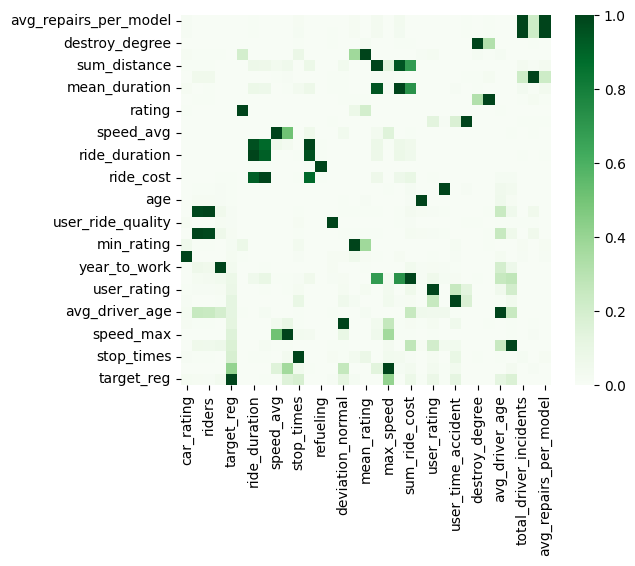

In [ ]:
corrs = car_info.dropna().corr().round(3).sort_values('target_reg')
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0)

**CatBoost**

In [ ]:
drop_cols = ['target_class', 'target_reg', 'ride_date', 'worker_id']
cat_cols = ['car_type', 'fuel_type', 'model', 'work_type']

X = car_info.drop(drop_cols, axis=1, errors = 'ignore')
y = car_info['target_class'].fillna(0)

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1,
                           iterations=100)
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)
fi = model.get_feature_importance(prettified=True)

Learning rate set to 0.295307
0:	learn: 1.0643667	test: 1.0606179	best: 1.0606179 (0)	total: 5.04s	remaining: 8m 18s
99:	learn: 0.0555025	test: 0.0560933	best: 0.0560933 (99)	total: 9m 20s	remaining: 0us

bestTest = 0.05609325765
bestIteration = 99



In [ ]:
fi

,Feature Id,Importances
0,max_speed,24.521301
1,mean_rating,24.056312
2,min_rating,8.682176
3,riders,6.556096
4,car_rating,4.770814
5,destroy_degree,3.834316
6,sum_distance,3.580617
7,year_to_work,3.315972
8,mean_duration,3.273309
9,sum_ride_cost,2.906877


**Permutation importance**

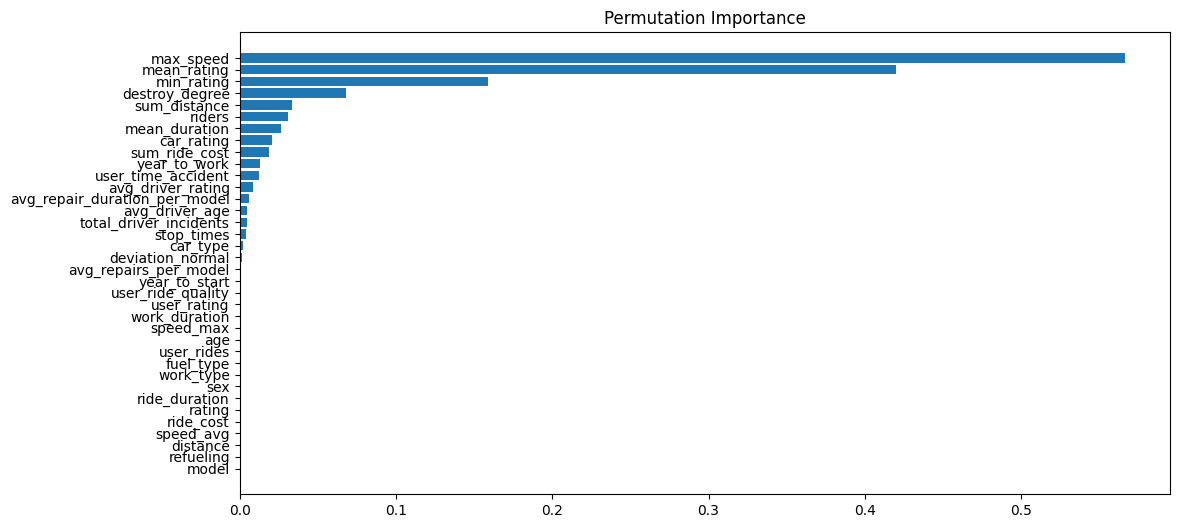

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

Стоит отметить, что ТОП-3 фичей совпадают для каждого из представленных методов: максимальная скорость, средний рейтинг и минимальный рейтинг. Данные признаки были получены нами на предыдущем шаге, что демонстрирует высокую степень влияния Feature Engineering на результаты обучения. Наблюдается большое количество признаков, которые никак не коррелируют с нашей целевой переменной, что довольно логично с учетом большого набора признаков. Датасет нуждается в дальнейшей очистке.

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

Классифицируем признаки на типы:

In [1]:
!pip install phik shap catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.5 MB/s eta 0:00:00


In [4]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

In [3]:
df=pd.read_csv('/content/drive/MyDrive/data/outt.csv', index_col=0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796316 entries, 9185093 to 2563470
Data columns (total 48 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   car_id                              796316 non-null  object 
 1   model                               796316 non-null  object 
 2   car_type                            796316 non-null  object 
 3   fuel_type                           796316 non-null  object 
 4   car_rating                          796316 non-null  float64
 5   year_to_start                       796316 non-null  int64  
 6   riders                              796316 non-null  int64  
 7   year_to_work                        796316 non-null  int64  
 8   target_reg                          796316 non-null  float64
 9   target_class                        796316 non-null  object 
 10  user_id                             796316 non-null  object 
 11  ride_id            

In [4]:
features2drop = ['car_id', 'fix_date', 'ride_id', 'user_id', 'deviation_normal_count', 'first_ride_date', 'fuel_type', 'model', 'work_type', 'rating', 'ride_duration', 'ride_cost', 'speed_avg', 'distance', 'refueling', 'age', 'sex', 'user_rides'] # то, что надо выбросить
targets = ['target_class', 'target_reg'] # таргеты
cat_features = ['car_type'] # категориальные признаки

num_features = ['max_speed', 'mean_rating', 'min_rating', 'riders', 'car_rating', 'total_rides', 'destroy_degree', 'sum_distance', 'year_to_work', 'mean_duration', 'sum_ride_cost', 'avg_driver_rating', 'avg_repair_duration_per_model', 'avg_driver_age', 'total_driver_incidents', 'user_time_accident', 'avg_repairs_per_model', 'stop_times', 'deviation_normal', 'year_to_start', 'user_ride_quality', 'user_rating', 'speed_max', 'work_duration', 'percent_high_destruction_incidents'] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 1 ['car_type']
Числовые признаки: 25 ['max_speed', 'mean_rating', 'min_rating', 'riders', 'car_rating', 'total_rides', 'destroy_degree', 'sum_distance', 'year_to_work', 'mean_duration', 'sum_ride_cost', 'avg_driver_rating', 'avg_repair_duration_per_model', 'avg_driver_age', 'total_driver_incidents', 'user_time_accident', 'avg_repairs_per_model', 'stop_times', 'deviation_normal', 'year_to_start', 'user_ride_quality', 'user_rating', 'speed_max', 'work_duration', 'percent_high_destruction_incidents']
Целевые переменные ['target_class', 'target_reg']


Выделяем в X только признаки, а в Y — таргет (для задачи классификации):

In [5]:
from sklearn.model_selection import train_test_split

df.drop(features2drop, axis=1, inplace=True, errors = 'ignore')
X = df[num_features+cat_features].drop(targets, axis=1, errors="ignore")
y = df["target_class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

CatBoost+Accuracy

In [ ]:
clf = CatBoostClassifier(thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features,
                         iterations=150,
                         depth=6,
                         learning_rate=0.1)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=100,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

0:	learn: 1.7298119	test: 1.7302688	best: 1.7302688 (0)	total: 2.83s	remaining: 7m 1s
100:	learn: 0.2075432	test: 0.2067872	best: 0.2067872 (100)	total: 4m 49s	remaining: 2m 20s
149:	learn: 0.1475423	test: 0.1470178	best: 0.1470178 (149)	total: 7m 8s	remaining: 0us

bestTest = 0.1470178327
bestIteration = 149



In [ ]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9672367892304601


# Дополнительное задание

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

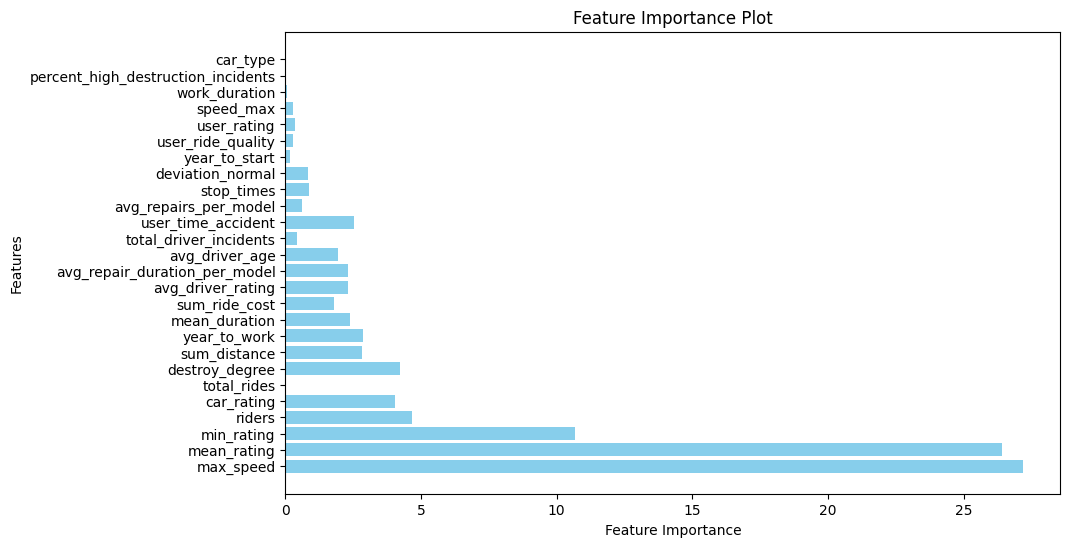

In [ ]:
import matplotlib.pyplot as plt

feature_importance = clf.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

Таким образом, ТОП-5 признаков по важности для предсказаний:

Максимальная скорость, средний рейтинг, минимальный рейтинг, количество пассажиров и рейтинг автомобиля. Данное распределение довольно логично, учитывая что мы пытаемся предсказать класс поломки, а подобные признаки напрямую влияют на износ.

In [ ]:
y_test.value_counts()

engine_overheat    19373
another_bug        19346
gear_stick         19284
engine_check       18507
engine_ignition    18452
break_bug          18388
engine_fuel        17809
electro_bug        16781
wheel_shake        11324
Name: target_class, dtype: int64

In [ ]:
!pip uninstall opencv-python -y -q
!pip install opencv-python shap -q

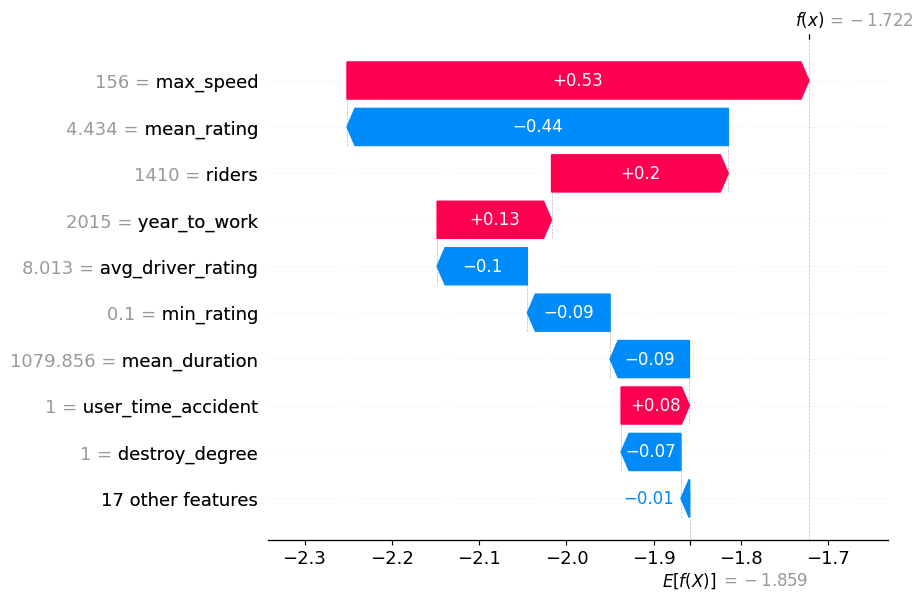

In [ ]:
import shap
from catboost import Pool

explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)

exp = shap.Explanation(shap_values[:,:,1], shap_values.base_values[:,1], X, feature_names=list(X))

idx = 50
shap.waterfall_plot(exp[idx])

Наибольшее влияние на прогноз оказывает максимальная скорость, что соответствует результатам по CatBoost. Большинство признаков не оказывают существенного влияния на прогноз, что может свидетельствовать о необходимости дополнительной очистки "мусорных" признаков.

In [ ]:
from sklearn.metrics import classification_report

target_names = ['engine_overheat', 'another_bug', 'gear_stick', 'engine_check', 'engine_ignition', 'break_bug', 'engine_fuel', 'electro_bug', 'wheel_shake']
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

engine_overheat       0.98      0.98      0.98     19346
    another_bug       1.00      1.00      1.00     18388
     gear_stick       1.00      1.00      1.00     16781
   engine_check       0.93      0.98      0.96     18507
engine_ignition       0.96      0.92      0.94     17809
      break_bug       0.94      0.94      0.94     18452
    engine_fuel       0.93      0.95      0.94     19373
    electro_bug       0.99      0.99      0.99     19284
    wheel_shake       0.98      0.91      0.95     11324

       accuracy                           0.97    159264
      macro avg       0.97      0.97      0.97    159264
   weighted avg       0.97      0.97      0.97    159264



Модель хорошо справляется с большинством классов, демонстрируя высокую точность, полноту, F1-меру и общую точность. Однако наблюдаются небольшие различия в производительности для разных классов (точность, полнота и F1-мера). В целом, модель проявляет сильные предиктивные способности для задачи многоклассовой классификации, но смущают значения в 1.0, возможно переобучение.

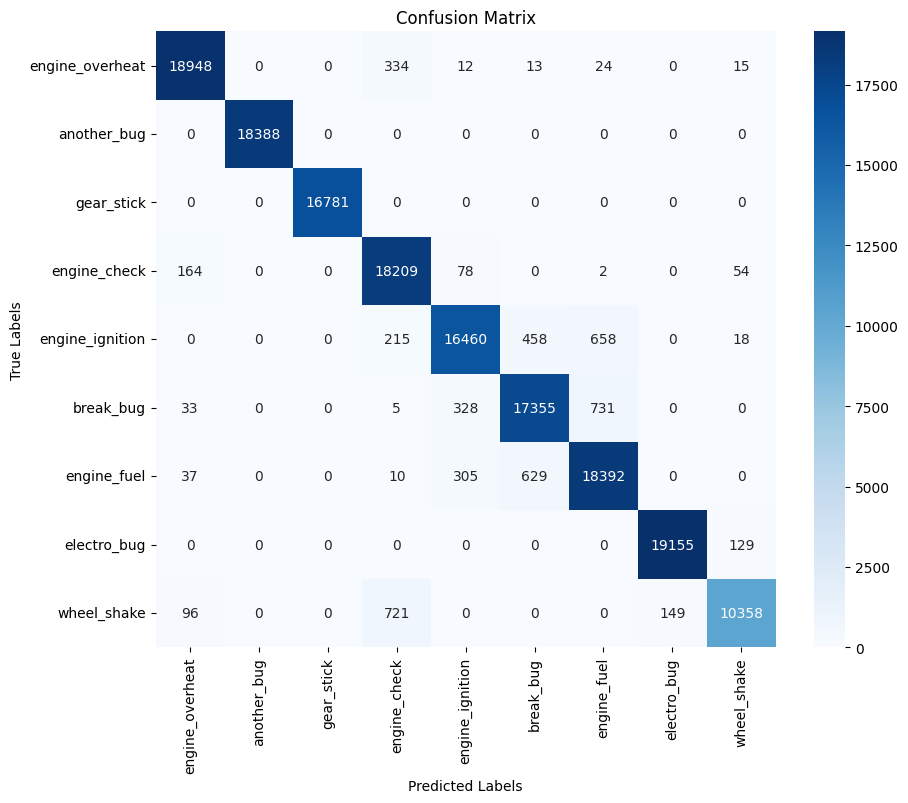

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Из предоставленных данных видно, что модель с высокой точностью предсказывает классы "another_bug", "gear_stick" и "engine_fuel", достигая значений точности, близких к 1.0. Однако для классов "engine_check", "engine_ignition", "break_bug" и "electro_bug" точность ниже, что может указывать на наличие сложно интерпретируемых или недообученных областей в данных. Особенно интересно, что хуже всего получается распознать "wheel_shake", для которого в датасете было меньше всего наблюдений, что указывает на недообученность модели на данных этого класса.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [2]:
!pip install optuna catboost -q

import optuna

import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.3 MB/s eta 0:00:00


In [6]:
def fit_catboost(trial, X_train, y_train, X_valid, y_valid):
    param = {
        'iterations': 100,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 50),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced"]),
        "depth": trial.suggest_int("depth", 3, 9),
        "used_ram_limit": "14gb",
        "eval_metric": "Accuracy",
    }

    cat_features = ['car_type']


    clf = CatBoostClassifier(
        **param,
        thread_count=-1,
        random_seed=42,
        cat_features=cat_features,
    )

    # Обучение модели
    clf.fit(
        X_train,
        y_train,
        eval_set=(X_valid, y_valid),
        verbose=0,
        plot=False,
        early_stopping_rounds=3,
    )

    # Прогноз на валидационной выборке
    y_pred = clf.predict(X_valid)
    return clf, y_pred

In [7]:
def objective(trial):
    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores = []

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # Подаем trials для перебора
        _, y_pred = fit_catboost(trial, X_train, y_train, X_valid, y_valid)
        scores.append(accuracy_score(y_valid, y_pred))

    result = np.mean(scores)

    return result

In [8]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15, n_jobs=-1, show_progress_bar=True)

[I 2024-04-01 16:26:10,243] A new study created in memory with name: no-name-c05840ba-4357-4fbe-a79a-2468a013c257


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-04-01 16:29:53,953] Trial 1 finished with value: 0.7989617191319501 and parameters: {'learning_rate': 0.007928076593786347, 'l2_leaf_reg': 38, 'auto_class_weights': 'SqrtBalanced', 'depth': 7}. Best is trial 1 with value: 0.7989617191319501.
[I 2024-04-01 16:31:25,449] Trial 2 finished with value: 0.4695372166551537 and parameters: {'learning_rate': 0.003929624383157973, 'l2_leaf_reg': 25, 'auto_class_weights': 'SqrtBalanced', 'depth': 3}. Best is trial 1 with value: 0.7989617191319501.
[I 2024-04-01 16:33:51,173] Trial 0 finished with value: 0.7992480382152695 and parameters: {'learning_rate': 0.008212433959161635, 'l2_leaf_reg': 14, 'auto_class_weights': 'Balanced', 'depth': 7}. Best is trial 0 with value: 0.7992480382152695.
[I 2024-04-01 16:33:51,214] Trial 3 finished with value: 0.7708999782087309 and parameters: {'learning_rate': 0.0011584309354524063, 'l2_leaf_reg': 45, 'auto_class_weights': 'SqrtBalanced', 'depth': 6}. Best is trial 0 with value: 0.7992480382152695.
[I 

In [9]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.8299619766521991, params {'learning_rate': 0.005349086333620865, 'l2_leaf_reg': 5, 'auto_class_weights': 'SqrtBalanced', 'depth': 9}


In [14]:
best_params = study.best_params
best_clf = CatBoostClassifier(**best_params, cat_features=cat_features, iterations=150)

best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

0:	learn: 2.1669479	total: 15.6s	remaining: 38m 39s
1:	learn: 2.1376618	total: 25.2s	remaining: 31m 4s
2:	learn: 2.1092230	total: 32s	remaining: 26m 7s
3:	learn: 2.0822612	total: 39.4s	remaining: 23m 57s
4:	learn: 2.0559896	total: 46.4s	remaining: 22m 25s
5:	learn: 2.0307260	total: 53.9s	remaining: 21m 33s
6:	learn: 2.0061752	total: 1m	remaining: 20m 40s
7:	learn: 1.9825339	total: 1m 8s	remaining: 20m 13s
8:	learn: 1.9596830	total: 1m 15s	remaining: 19m 45s
9:	learn: 1.9376581	total: 1m 23s	remaining: 19m 28s
10:	learn: 1.9162475	total: 1m 30s	remaining: 19m 9s
11:	learn: 1.8953993	total: 1m 39s	remaining: 19m 1s
12:	learn: 1.8751800	total: 1m 45s	remaining: 18m 31s
13:	learn: 1.8555602	total: 1m 53s	remaining: 18m 21s
14:	learn: 1.8361976	total: 1m 59s	remaining: 17m 57s
15:	learn: 1.8174702	total: 2m 8s	remaining: 17m 54s
16:	learn: 1.7994381	total: 2m 14s	remaining: 17m 34s
17:	learn: 1.7816647	total: 2m 22s	remaining: 17m 28s
18:	learn: 1.7642876	total: 2m 29s	remaining: 17m 9s
19:

In [15]:
optuna.visualization.plot_param_importances(study)

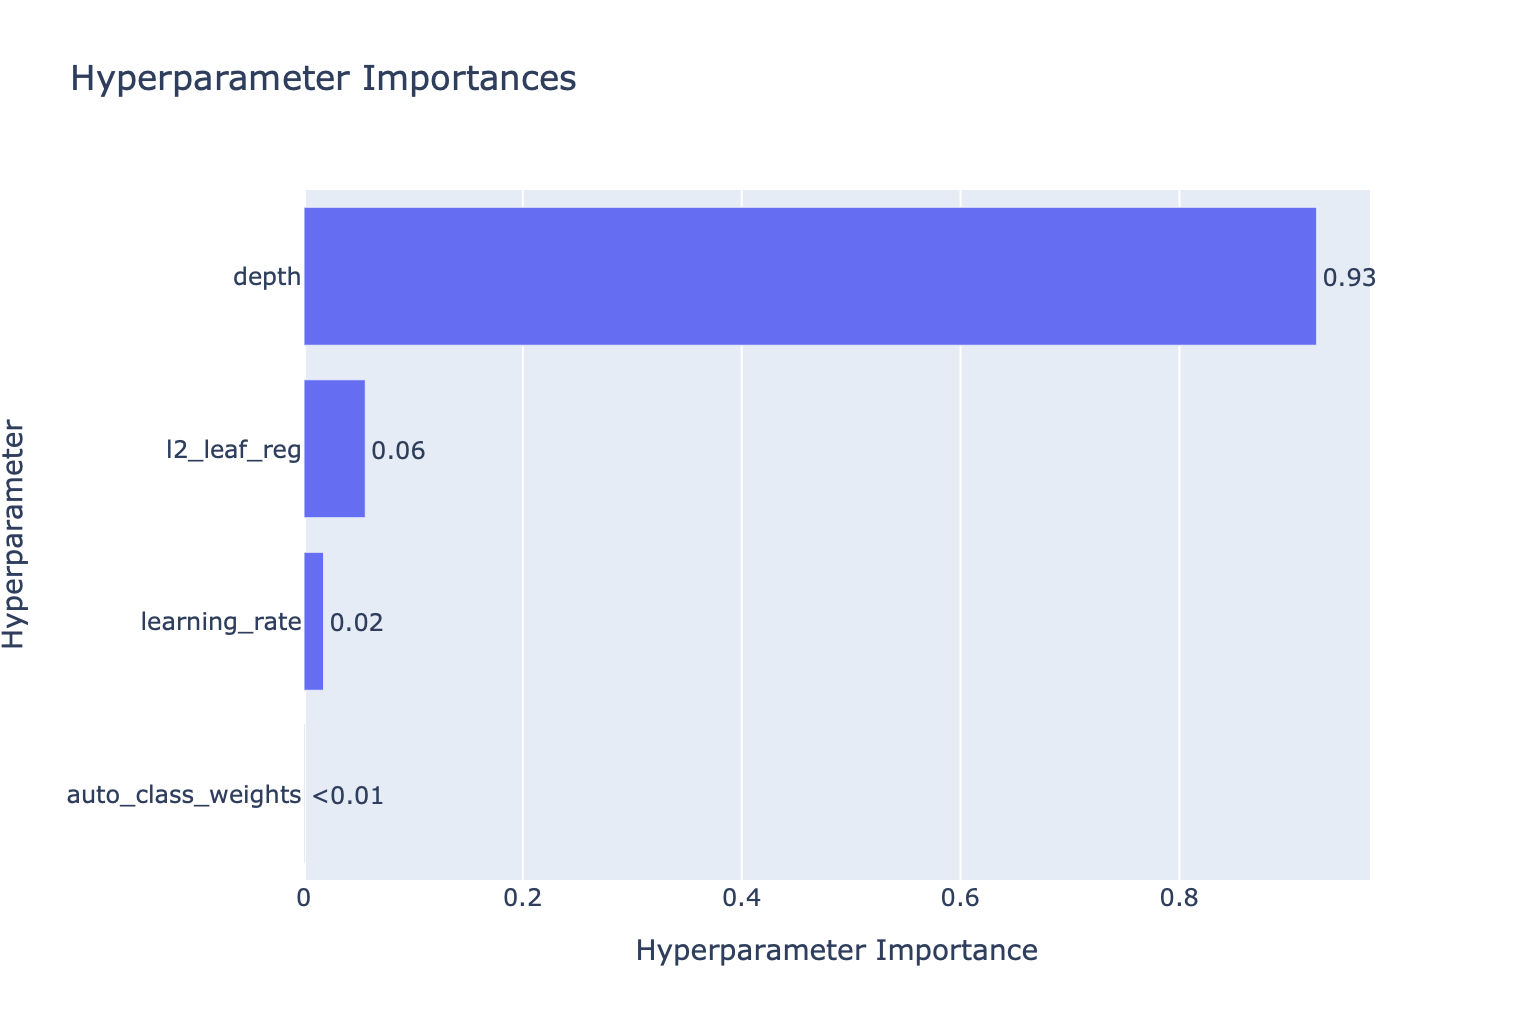

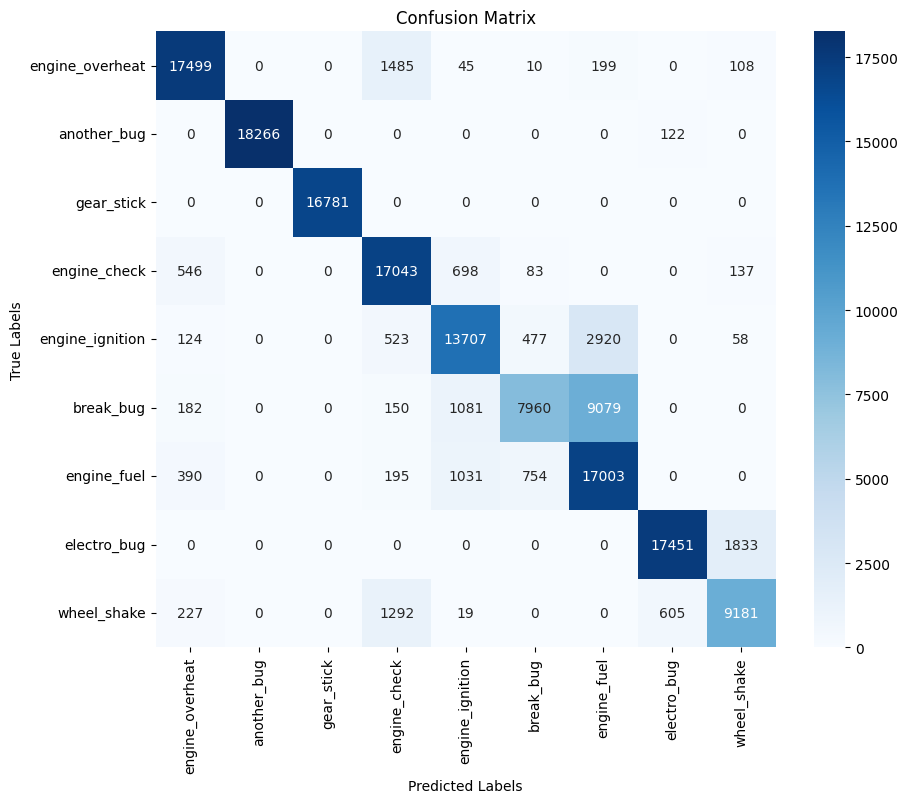

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['engine_overheat', 'another_bug', 'gear_stick', 'engine_check', 'engine_ignition', 'break_bug', 'engine_fuel', 'electro_bug', 'wheel_shake']
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Вывод**: Accuracy модели без настройки гиперпараметров: 0.9672367892304601

Accuracy модели с использованием Optuna: 0.8469647880249146

Дополнительно вывела confusion matrix, чтобы убедиться в том, что классы действительно хуже выявляются.

Таким образом, несмотря на ухудшение результатов метрики, можно сделать ряд полезных выводов:

* Для обучения использовалась урезанная версия исходного датасета. Возможно, в случае небольшого объема исходных данных нет необходимости в использовании продвинутых процедур настройки гиперпараметров.

* В ходе попыток запуска оптимизации я столкнулась с большой нехваткой вычислительных мощностей, из-за чего подобранные гиперпараметры могут быть не самыми оптимальными, плюс происходил перебор лишь 4-х гиперпараметров. Возможно, не самых эффективных для данной модели. Таким образом, для подобных процедур необходим большой объем вычислительных мощностей. В случае их отсутствия мы можем не просто не улучшить метрику, но и ухудшить ее.

* Эксперимент нуждается в доработке в более устойчивой среде выполнения.

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.